# BSS: Basketball Statistic System

This system tries to replicate [euRobasketAu](https://github.com/jgalowe/euRobasketAu?organization=jgalowe&organization=jgalowe) R scripts in Python.

It scrapes the data and then converts the raw numbers into _advanced stats_.

The data is provided live by [Genius Sports ](https://developer.geniussports.com/). The documentation for the Basketball feed can be found [here](https://developer.geniussports.com/livestats/tvfeed/index_basketball.html).

Messages are sent in JSON structures and use UTF-8 format.

An example of a raw JSON file:

https://fibalivestats.dcd.shared.geniussports.com/data/2087737/data.json

In [1]:
# Let's first load all required packages...
import json  # https://docs.python.org/3/library/json.html
import os
import pandas as pd
import numpy as np
import datetime
import re

# Load constants
from config import *
import tools

## 1. Build basic PBP dataframe from JSON data

In [2]:
# Load relevant game data
game_id = 742430
game_id = 2087737

game_json = tools.get_json_data(game_id)
pbp_df = tools.get_pbp_df(game_json)

# pbp_df.insert(0, 'game', game_id)
# pbp_df.set_index(['actionNumber'], inplace=True)

# pbp_df.sample(20)
pbp_df.info()
pbp_df.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 566 entries, 563 to 1
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   team_name        566 non-null    object
 1   team_short_name  566 non-null    object
 2   clock            566 non-null    object
 3   s1               566 non-null    int64 
 4   s2               566 non-null    int64 
 5   lead             566 non-null    int64 
 6   tno              566 non-null    int64 
 7   period           566 non-null    int64 
 8   periodType       566 non-null    object
 9   pno              566 non-null    int64 
 10  player           566 non-null    object
 11  success          566 non-null    int64 
 12  actionType       566 non-null    object
 13  actionNumber     566 non-null    int64 
 14  previousAction   566 non-null    object
 15  qualifier        566 non-null    object
 16  subType          566 non-null    object
 17  scoring          566 non-null    in

,team_name,team_short_name,clock,s1,s2,lead,tno,period,periodType,pno,player,success,actionType,actionNumber,previousAction,qualifier,subType,scoring
563,,,00:10:00,0,0,0,0,1,REGULAR,0,,1,jumpball,4,,[],startperiod,0
564,,,00:10:00,0,0,0,0,1,REGULAR,0,,1,period,2,,[],start,0
565,,,00:10:00,0,0,0,0,1,REGULAR,0,,1,game,1,,[],start,0
561,Melbourne United,United,00:09:56,0,0,0,1,1,REGULAR,10,J. Lual-Acuil Jr,1,jumpball,7,4,[],lost,0
562,Tasmania JackJumpers,JackJumpers,00:09:56,0,0,0,2,1,REGULAR,9,F. Krslovic,1,jumpball,6,4,[],won,0
560,Tasmania JackJumpers,JackJumpers,00:09:42,0,0,0,2,1,REGULAR,9,F. Krslovic,0,3pt,9,,[],jumpshot,1
559,Melbourne United,United,00:09:38,0,0,0,1,1,REGULAR,6,J. White,1,rebound,10,9,[],defensive,0
558,Melbourne United,United,00:09:31,0,0,0,1,1,REGULAR,6,J. White,0,3pt,11,,[],jumpshot,1
557,Tasmania JackJumpers,JackJumpers,00:09:27,0,0,0,2,1,REGULAR,9,F. Krslovic,1,rebound,12,11,[],defensive,0
556,Tasmania JackJumpers,JackJumpers,00:09:22,0,0,0,2,1,REGULAR,11,J. Adams,0,3pt,13,,[],pullupjumpshot,1


Check that players' name do not contain the shirt number:

In [3]:
# just check that no player name has a number on it or a comma
pbp_df.loc[pbp_df['player'].str.contains('\d') | pbp_df['player'].str.contains(',')]

,team_name,team_short_name,clock,s1,s2,lead,tno,period,periodType,pno,player,success,actionType,actionNumber,previousAction,qualifier,subType,scoring


In [4]:
pbp_cols = list(pbp_df.columns)
pbp_cols

['team_name',
 'team_short_name',
 'clock',
 's1',
 's2',
 'lead',
 'tno',
 'period',
 'periodType',
 'pno',
 'player',
 'success',
 'actionType',
 'actionNumber',
 'previousAction',
 'qualifier',
 'subType',
 'scoring']

## 2. Extract stints from pbp data

A stint is a lineup that plays in different periods across the game. Starting from the starting lineup, we parse each pbp to build the various stints for each team and the periods each team's stint play across the game.

The stint data is stored in a dictionary:

* key: set of players' names.
* value: list of intervals. 

An interval is tuple `(period no, left datetime.time, right datetime.time)`

In [5]:
# Extract names of teams in the game
team_names = tools.get_team_names(game_json)
team_name_1, team_short_name_1 = team_names[0]
team_name_2, team_short_name_2 = team_names[1]

print(f"Game {team_name_1} ({team_short_name_1}) vs {team_name_2} ({team_short_name_2})")

starters_1 = tools.get_starters(game_json, 1)
starters_2 = tools.get_starters(game_json, 2)
for x in zip([team_name_1, team_name_2], [starters_1, starters_2]):
    print(f"Starters for {x[0]}:")
    print(f"\t {x[1]}")


Game Melbourne United (United) vs Tasmania JackJumpers (JackJumpers)
Starters for Melbourne United:
	 {'M. Dellavedova', 'C. Agada', 'J. White', 'S. Ili', 'J. Lual-Acuil Jr'}
Starters for Tasmania JackJumpers:
	 {'J. Mcveigh', 'F. Krslovic', 'J. Adams', 'J. Magette', 'M. Kenyon'}


Calculate stints data dictionaries for each team:

In [6]:
stints_1 = tools.pbp_stints_extract(pbp_df, starters_1, 1)
stints_2 = tools.pbp_stints_extract(pbp_df, starters_2, 2)

stints_1

{frozenset({'C. Agada',
            'J. Lual-Acuil Jr',
            'J. White',
            'M. Dellavedova',
            'S. Ili'}): [(1, datetime.time(0, 10), datetime.time(0, 5, 53)),
  (2, datetime.time(0, 10), datetime.time(0, 7, 36)),
  (3, datetime.time(0, 10), datetime.time(0, 7, 6)),
  (4, datetime.time(0, 2, 42), datetime.time(0, 1, 20))],
 frozenset({'C. Agada',
            'J. Lual-Acuil Jr',
            'J. White',
            'M. Dellavedova',
            'Y. Baba'}): [(1, datetime.time(0, 5, 53), datetime.time(0, 5, 5)),
  (2, datetime.time(0, 7, 36), datetime.time(0, 4, 46)),
  (3, datetime.time(0, 5, 7), datetime.time(0, 4, 21)),
  (4, datetime.time(0, 7, 28), datetime.time(0, 5, 36))],
 frozenset({'B. Newley',
            'J. Lual-Acuil Jr',
            'J. White',
            'M. Dellavedova',
            'Y. Baba'}): [(1,
   datetime.time(0, 5, 5),
   datetime.time(0, 4, 29))],
 frozenset({'B. Newley',
            'J. Lual-Acuil Jr',
            'M. Peatling',
     

Add columns to pbp dataframe for stint identification. Columns `stint1` and `stint2` will refer to the stint id of team 1 or 2, resp., at that play. 

In [7]:
stints1_df, pbp_aux_df = tools.pbp_add_stint_col(pbp_df, stints_1, "stint1")
stints2_df, pbp_aux_df = tools.pbp_add_stint_col(pbp_aux_df, stints_2, "stint2")

# drop plays that are not for statistics (game events, like start/end)
pbp2_df = pbp_aux_df.loc[(~pbp_aux_df['actionType'].isin(ACT_NON_STATS))]
pbp2_df = pbp2_df.loc[(~pbp_aux_df['subType'].isin(ACTSSUB_NON_STATS))]

pbp2_df.head(5)

# should give empty: every row is a play
# pbp2_df.loc[pbp2_df['stint1'] == -1]

,team_name,team_short_name,clock,s1,s2,lead,tno,period,periodType,pno,player,success,actionType,actionNumber,previousAction,qualifier,subType,scoring,stint1,stint2
561,Melbourne United,United,00:09:56,0,0,0,1,1,REGULAR,10,J. Lual-Acuil Jr,1,jumpball,7,4,[],lost,0,1,1
562,Tasmania JackJumpers,JackJumpers,00:09:56,0,0,0,2,1,REGULAR,9,F. Krslovic,1,jumpball,6,4,[],won,0,1,1
560,Tasmania JackJumpers,JackJumpers,00:09:42,0,0,0,2,1,REGULAR,9,F. Krslovic,0,3pt,9,,[],jumpshot,1,1,1
559,Melbourne United,United,00:09:38,0,0,0,1,1,REGULAR,6,J. White,1,rebound,10,9,[],defensive,0,1,1
558,Melbourne United,United,00:09:31,0,0,0,1,1,REGULAR,6,J. White,0,3pt,11,,[],jumpshot,1,1,1


In [8]:
# An example of a record in the pbp stats dataframe (see stints colums)
pbp2_df.loc[4]

team_name          Tasmania JackJumpers
team_short_name             JackJumpers
clock                   00:00:11.600000
s1                                   71
s2                                   76
lead                                 -5
tno                                   2
period                                4
periodType                      REGULAR
pno                                  14
player                      M. McIntosh
success                               1
actionType                      rebound
actionNumber                        769
previousAction                      768
qualifier                            []
subType                       defensive
scoring                               0
stint1                               12
stint2                               19
Name: 4, dtype: object

## 3. Statistics

First, let's extract the plays of the starting lineup for team 1.

In [9]:
# Let's do some stats with the starting team
lineaup = frozenset(starters_1) # we need a hashable
interval = stints_1[lineaup]

df = tools.pbp_get_ranges_df(pbp2_df, interval)
df.loc[df['period'] == 4]

/home/ssardina/git/soft/data-science/bball.git/tools.py:249: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return pbp_df[pbp_get_ranges_mask(pbp_df, time_intervals)]


,team_name,team_short_name,clock,s1,s2,lead,tno,period,periodType,pno,player,success,actionType,actionNumber,previousAction,qualifier,subType,scoring,stint1,stint2
57,Tasmania JackJumpers,JackJumpers,00:02:42,64,71,-7,2,4,REGULAR,11,J. Adams,1,freethrow,689,,"[fastbreak, fromturnover]",2of2,1,1,18
58,Tasmania JackJumpers,JackJumpers,00:02:42,64,70,-6,2,4,REGULAR,11,J. Adams,1,freethrow,688,,"[fastbreak, fromturnover]",1of2,1,1,18
59,Tasmania JackJumpers,JackJumpers,00:02:42,64,69,-5,2,4,REGULAR,11,J. Adams,1,foulon,687,686,[],,0,1,18
60,Melbourne United,United,00:02:42,64,69,-5,1,4,REGULAR,16,C. Agada,1,foul,686,,"[shooting, 2freethrow]",personal,0,1,18
54,Melbourne United,United,00:02:24,64,71,-7,1,4,REGULAR,13,M. Dellavedova,0,2pt,695,,[pointsinthepaint],pullupjumpshot,1,1,18
52,Melbourne United,United,00:02:21,64,71,-7,1,4,REGULAR,6,J. White,0,2pt,697,,"[2ndchance, pointsinthepaint]",layup,1,1,18
53,Melbourne United,United,00:02:21,64,71,-7,1,4,REGULAR,6,J. White,1,rebound,696,695,[],offensive,0,1,18
51,Tasmania JackJumpers,JackJumpers,00:02:17,64,71,-7,2,4,REGULAR,14,M. McIntosh,1,rebound,698,697,[],defensive,0,1,18
50,Tasmania JackJumpers,JackJumpers,00:02:04,64,71,-7,2,4,REGULAR,12,J. Magette,0,3pt,699,,[],pullupjumpshot,1,1,18
49,Tasmania JackJumpers,JackJumpers,00:02:01,64,71,-7,2,4,REGULAR,14,M. McIntosh,1,rebound,700,699,[],offensive,0,1,18


Inspect possible actions in a play

In [10]:
# inspect all actions and sub-actions that can be done in a play
actions = tools.pbp_get_actions(pbp2_df)
actions

,subType
actionType,
2pt,dunk
2pt,turnaroundjumpshot
2pt,layup
2pt,drivinglayup
2pt,floatingjumpshot
2pt,pullupjumpshot
2pt,hookshot
2pt,stepbackjumpshot
2pt,jumpshot


Let's do a pivot table. Doc:

* https://pandas.pydata.org/docs/user_guide/reshaping.html
* https://nikgrozev.com/2015/07/01/reshaping-in-pandas-pivot-pivot-table-stack-and-unstack-explained-with-pictures/


In [11]:
pivot_stat = pbp2_df.pivot_table(
    index=['team_short_name', 'stint1'],
    columns=['actionType', 'subType'],
    values='actionNumber', aggfunc=len, fill_value=0)
# pivot_stat.info()
# pivot_stat.reset_index(inplace=True)

pivot_stat['2pt']

subType                 drivinglayup  dunk  fadeaway  floatingjumpshot  \
team_short_name stint1                                                   
JackJumpers     1                  2     0         0                 0   
                2                  3     0         0                 0   
                3                  0     0         0                 0   
                4                  0     0         0                 0   
                5                  0     0         0                 0   
                6                  0     0         0                 0   
                7                  1     0         0                 0   
                8                  0     0         0                 1   
                9                  0     0         1                 0   
                10                 1     0         0                 0   
                11                 0     0         0                 0   
                12                 1     0         0                 0   
                13                 0     0         0                 0   
                14                 0     0         0                 1   
                15                 0     0         0                 0   
                16                 0     0         0                 0   
                17                 0     0         0                 0   
United          1                  1     1         0                 1   
                2                  1     1         0                 0   
                4                  0     0         0                 0   
                5                  0     0         0                 0   
                6                  0     0         0                 0   
                7                  0     0         0                 0   
                8                  1     0         0                 0   
                9                  0     0         0                 0   
                10                 0     0         0                 1   
                11                 0     0         0                 0   
                12                 1     2         0                 0   
                13                 0     0         0                 0   
                14                 0     0         0                 0   
                15                 1     0         0                 0   
                16                 0     0         0                 0   
                17                 0     0         0                 0   

subType                 hookshot  jumpshot  layup  pullupjumpshot  \
team_short_name stint1                                              
JackJumpers     1              0         2      3               2   
                2              2         1      1               1   
                3              0         0      0               1   
                4              0         0      1               0   
                5              0         0      4               0   
                6              0         0      0               0   
                7              0         0      0               0   
                8              0         0      0               0   
                9              0         0      1               0   
                10             0         0      0               0   
                11             0         0      1               0   
                12             0         0      3               1   
                13             0         0      0               0   
                14             0         0      0               0   
                15             0         0      0               0   
                16             0         0      0               2   
                17             0         0      0               0   
United          1              0         0      6               2   
                2            

In [12]:
# columns are in two levels
pivot_stat.columns


MultiIndex([(      '2pt',       'drivinglayup'),
            (      '2pt',               'dunk'),
            (      '2pt',           'fadeaway'),
            (      '2pt',   'floatingjumpshot'),
            (      '2pt',           'hookshot'),
            (      '2pt',           'jumpshot'),
            (      '2pt',              'layup'),
            (      '2pt',     'pullupjumpshot'),
            (      '2pt',   'stepbackjumpshot'),
            (      '2pt', 'turnaroundjumpshot'),
            (      '3pt',           'jumpshot'),
            (      '3pt',     'pullupjumpshot'),
            (      '3pt',   'stepbackjumpshot'),
            (   'assist',                   ''),
            (    'block',                   ''),
            (     'foul',          'offensive'),
            (     'foul',           'personal'),
            (   'foulon',                   ''),
            ('freethrow',               '1of1'),
            ('freethrow',               '1of2'),
            ('freeth

In [13]:
# Collapse two level columns into single level
pivot_stat2_df = pivot_stat.copy()

# collapse complex columns into a single flat one
pivot_stat2_df.columns = ['_'.join(col) for col in pivot_stat.columns.values]
pivot_stat2_df.columns
# pivot_stat2_df.head()

Index(['2pt_drivinglayup', '2pt_dunk', '2pt_fadeaway', '2pt_floatingjumpshot',
       '2pt_hookshot', '2pt_jumpshot', '2pt_layup', '2pt_pullupjumpshot',
       '2pt_stepbackjumpshot', '2pt_turnaroundjumpshot', '3pt_jumpshot',
       '3pt_pullupjumpshot', '3pt_stepbackjumpshot', 'assist_', 'block_',
       'foul_offensive', 'foul_personal', 'foulon_', 'freethrow_1of1',
       'freethrow_1of2', 'freethrow_2of2', 'jumpball_lost', 'jumpball_won',
       'rebound_defensive', 'rebound_offensive', 'rebound_offensivedeadball',
       'steal_', 'timeout_full', 'turnover_badpass', 'turnover_ballhandling',
       'turnover_offensive', 'turnover_outofbounds'],
      dtype='object')

In [14]:
pivot_stat2_df.to_csv("stint1_stats.csv", index=False)

## Build complex stint stat table

In [31]:
from functools import reduce

def build_stint_stats(pbp_df: pd.DataFrame, tno: int, col_name: str) -> pd.DataFrame:
    """Builds stats table aggregated by column col_name (usually, a stint column, with stint id for a team)

    Args:
        pbp_df (pd.DataFrame): a play-by-play table with a column called col_name
        tno (int): the team to extract data (1 or 2)
        col_name (str): the column to aggregate data (e.g., stints of a team)

    Returns:
        pd.DataFrame: a table with various stats for each value in col_name
    """
    # tuples (name, default value, True if attemps/made/per, mask)
    stats = [ ('AST', 0, False, pbp_df['actionType'] == 'assist'),
             # points
            ('2pt_fg', 0, True, pbp_df['actionType'] == '2pt'),
            ('patr', 0, True, pbp_df['subType'].isin(['layup', 'drivinglayup', 'dunk'])),
            ('3pt_fg', 0, True, pbp_df['actionType'] == '3pt'),
            ('ft', 0, True, pbp_df['actionType'] == 'freethrow'),
            # others
            ('rebs', 0, False, pbp_df['actionType'] == 'rebound'),
            ('orebs', 0, False, (pbp_df['actionType'] == 'rebound') & (pbp_df['subType'] == 'offensive')),
            ('drebs', 0, False, (pbp_df['actionType'] == 'rebound') & (pbp_df['subType'] == 'defensive')),
            ('steals', 0, False, pbp_df['actionType'] == 'steal'),
            ('blocks', 0, False, pbp_df['actionType'] == 'block'),
             #turnover types
            ('tovs', 0, False, pbp_df['actionType'] == 'turnover'),
            ('ballhand', 0, False, (pbp_df['actionType'] == 'turnover') &
                                    (pbp_df['subType'].isin(['ballhandling', 'doubledribble', 'travel'])) ),
            ('badpass', 0, False, (pbp_df['actionType'] == 'turnover') & (pbp_df['subType'] == 'badpass') ),
            ('ofoul', 0, False, (pbp_df['actionType'] == 'turnover') & (pbp_df['subType'] == 'offensive') ),
            ('3sec', 0, False, (pbp_df['actionType'] == 'turnover') & (pbp_df['subType'] == '3sec') ),
            ('8sec', 0, False, (pbp_df['actionType'] == 'turnover') & (pbp_df['subType'] == '8sec') ),
            ('24sec', 0, False, (pbp_df['actionType'] == 'turnover') & (pbp_df['subType'] == '24sec') )
    ]
    stats_opp = [(f"opp_{x[0]}",) + x[1:] for x in stats]

    stats_dfs = [pd.DataFrame({col_name : pbp_df[col_name].unique()})] # dummy df for left join
    for x in [(stats, tno), (stats_opp, 2 if tno==1 else 1)]:   # do stats for team and opponent plays
        pbp_team_df = pbp_df.loc[pbp_df['tno'] == x[1]]  # plays of the team

        # compute a dataframe (and add it to stats_dfs) for each stat
        for stat in x[0]:
            name, default, rate, mask = stat
            name_a = f'{name}a' if rate else name
            name_m = f'{name}m'
            name_p = f'{name}p'

            # record basic stat (attempts when rate)
            df = pbp_team_df.loc[mask].groupby(col_name).size().reset_index(name=name_a)

            if rate:
                df2 = pbp_team_df.loc[mask & (pbp_team_df['success'] == 1)].groupby(col_name).size().reset_index(name=name_m)
                df2.fillna(default, inplace=True)

                df = df.merge(df2, "left")
                df[name_p] = round((df[name_m] / df[name_a])*100, 2)

            df.fillna(default, inplace=True)    #TODO: seems not working, why?
            stats_dfs.append(df)


            # finally, join all dfs computed (one per stat)
            df = reduce(lambda df1, df2: df1.merge(df2, "left"), stats_dfs)
            df.fillna(0, inplace=True)

        # now, calculate complex stats from prev columns using the merged df
        # --------------------------------------------------
        prefix = "" if tno == x[1] else "opp_"
        f_pts = f'{prefix}pts'
        f_2pt_fga = f'{prefix}2pt_fga'
        f_2pt_fgm = f'{prefix}2pt_fgm'
        f_3pt_fga = f'{prefix}3pt_fga'
        f_3pt_fgm = f'{prefix}3pt_fgm'
        f_fta = f'{prefix}fta'
        f_ftm = f'{prefix}ftm'
        f_poss = f'{prefix}poss'
        f_tovs = f'{prefix}tovs'
        f_orebs = f'{prefix}orebs'

        f_fga = f'{prefix}fga'
        f_fgm = f'{prefix}fgm'
        f_fgp = f'{prefix}fgp'

        df[f_pts] = 2*df[f_2pt_fgm] + 3*df[f_3pt_fgm] + df[f_ftm]

        # # calculate home possesions (possessions only count change of hands, not offensive rebounds and new shots)
        df[f_poss] = df[f_2pt_fga] + df[f_3pt_fga] + 0.44*df[f_fta] + df[f_tovs] - df[f_orebs]
        df.loc[df[f_poss] < 0, f_poss] = 0

        # calculate shooting stats
        df[f_fga] = df[f_2pt_fga] + df[f_3pt_fga]
        df[f_fgm] = df[f_2pt_fgm] + df[f_3pt_fgm]
        df[f_fgp] = round(100*(df[f_fgm] / df[f_fga]), 2)

        stats_dfs = [df]    # reset stats_def to final df for that team

    df = stats_dfs[0]

    # calculate ortg, drtg and netrtg
    df['ortg'] = round(df['pts'] / df['poss'], 2)
    df['drtg'] = round(df['opp_pts'] / df['opp_poss'], 2)
    df['net_rtg'] = df['ortg'] - df['drtg']




#    `team_paint_fg%` = round(100*((sum(lineup_dat$team_pfgm)/sum(lineup_dat$team_pfga))))
    
#    `team_3p%` = round(100*(sum(lineup_dat$team_fgm3)/sum(lineup_dat$team_fga3)))

#    `team_ft%` = round(100*(sum(lineup_dat$team_ftm)/sum(lineup_dat$team_fta)))

#    `team_ts%` = round(100*(sum(lineup_dat$team_pts)/(2*(team_fga + 0.44*sum(lineup_dat$team_fta)))),2)

#    `%fgm_as` = round(100*(sum(lineup_dat$team_ast)/(sum(lineup_dat$team_fgm2) +  sum(lineup_dat$team_fgm3))),2)



    return df



##############################################
# Compute stint stat data for team 1 and 2 and union in a single df
##############################################
stint1_stats_df = build_stint_stats(pbp2_df, 1, 'stint1')
stint1_stats_df.rename(columns={'stint1' : 'stint'}, inplace=True)
stint1_stats_df.insert(0, 'tno', 1)

stint2_stats_df = build_stint_stats(pbp2_df, 2, 'stint2')
stint2_stats_df.rename(columns={'stint2' : 'stint'}, inplace=True)
stint2_stats_df.insert(0, 'tno', 2)

stint_stats_df = pd.concat([stint1_stats_df, stint2_stats_df])
stint_stats_df  # final df


,tno,stint,AST,2pt_fga,2pt_fgm,2pt_fgp,patra,patrm,patrp,3pt_fga,...,opp_8sec,opp_24sec,opp_pts,opp_poss,opp_fga,opp_fgm,opp_fgp,ortg,drtg,net_rtg
0,1,1,5.0,13.0,8.0,61.54,8.0,7.0,87.50,5.0,...,0.0,0.0,15.0,17.88,18.0,5.0,27.78,1.01,0.84,0.17
1,1,2,1.0,5.0,3.0,60.00,4.0,3.0,75.00,4.0,...,0.0,0.0,10.0,9.88,13.0,4.0,30.77,0.74,1.01,-0.27
2,1,3,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,...,0.0,0.0,2.0,1.00,1.0,1.0,100.00,NaN,2.00,NaN
3,1,4,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,...,0.0,0.0,4.0,2.00,2.0,2.0,100.00,0.69,2.00,-1.31
4,1,5,1.0,0.0,0.0,0.00,0.0,0.0,0.00,2.0,...,0.0,0.0,8.0,5.44,6.0,3.0,50.00,2.06,1.47,0.59
5,1,6,0.0,1.0,1.0,100.00,1.0,1.0,100.00,1.0,...,0.0,0.0,0.0,0.00,0.0,0.0,NaN,2.27,NaN,NaN
6,1,7,0.0,3.0,2.0,66.67,3.0,2.0,66.67,1.0,...,0.0,0.0,2.0,3.00,2.0,1.0,50.00,1.33,0.67,0.66
7,1,8,0.0,1.0,0.0,0.00,1.0,0.0,0.00,0.0,...,0.0,0.0,2.0,1.88,2.0,0.0,0.00,0.00,1.06,-1.06
8,1,9,1.0,1.0,1.0,100.00,0.0,0.0,0.00,1.0,...,0.0,0.0,4.0,2.88,2.0,1.0,50.00,1.04,1.39,-0.35
9,1,10,1.0,1.0,0.0,0.00,0.0,0.0,0.00,1.0,...,0.0,0.0,5.0,2.44,2.0,2.0,100.00,1.50,2.05,-0.55


In [63]:
from functools import reduce

percent = lambda part, whole: round(100* (part / whole), 2)

def build_stint_stats(pbp_df: pd.DataFrame, col_name: str) -> pd.DataFrame:
    """Builds stats table aggregated by column col_name (usually, a stint column, with stint id for a team)

    Args:
        pbp_df (pd.DataFrame): a play-by-play table with a column called col_name
        col_name (str): the column to aggregate data (e.g., stints of a team)

    Returns:
        pd.DataFrame: a table with various stats for each value in col_name
    """

    # tuples (name, default value, True if attemps/made/per, mask)
    stats = [ ('ast', 0, False, pbp_df['actionType'] == 'assist'),
             # points
            ('2pt_fg', 0, True, pbp_df['actionType'] == '2pt'),
            ('patr', 0, True, pbp_df['subType'].isin(['layup', 'drivinglayup', 'dunk'])),
            ('3pt_fg', 0, True, pbp_df['actionType'] == '3pt'),
            ('ft', 0, True, pbp_df['actionType'] == 'freethrow'),
            # others
            ('rebs', 0, False, pbp_df['actionType'] == 'rebound'),
            ('orebs', 0, False, (pbp_df['actionType'] == 'rebound') & (pbp_df['subType'] == 'offensive')),
            ('drebs', 0, False, (pbp_df['actionType'] == 'rebound') & (pbp_df['subType'] == 'defensive')),
            ('steals', 0, False, pbp_df['actionType'] == 'steal'),
            ('blocks', 0, False, pbp_df['actionType'] == 'block'),
             #turnover types
            ('tovs', 0, False, pbp_df['actionType'] == 'turnover'),
            ('ballhand', 0, False, (pbp_df['actionType'] == 'turnover') &
                                    (pbp_df['subType'].isin(['ballhandling', 'doubledribble', 'travel'])) ),
            ('badpass', 0, False, (pbp_df['actionType'] == 'turnover') & (pbp_df['subType'] == 'badpass') ),
            ('ofoul', 0, False, (pbp_df['actionType'] == 'turnover') & (pbp_df['subType'] == 'offensive') ),
            ('3sec', 0, False, (pbp_df['actionType'] == 'turnover') & (pbp_df['subType'] == '3sec') ),
            ('8sec', 0, False, (pbp_df['actionType'] == 'turnover') & (pbp_df['subType'] == '8sec') ),
            ('24sec', 0, False, (pbp_df['actionType'] == 'turnover') & (pbp_df['subType'] == '24sec') )
    ]
    stats_dfs = [pd.DataFrame({col_name : pbp_df[col_name].unique()})] # dummy df for left join
    # compute a dataframe (and add it to stats_dfs) for each stat
    for stat in stats:
        name, default, rate, mask = stat
        name_a = f'{name}a' if rate else name
        name_m = f'{name}m'
        name_p = f'{name}p'

        # count no of plays that stat shows up (e.g., 2pt_fga)
        df = pbp_df.loc[mask].groupby(col_name).size().reset_index(name=name_a)

        if rate:
            df2 = pbp_df.loc[mask & (pbp_df['success'] == 1)].groupby(col_name).size().reset_index(name=name_m)
            df2.fillna(default, inplace=True)

            df = df.merge(df2, "left")
            df[name_p] = percent(df[name_m], df[name_a])

        df.fillna(default, inplace=True)    #TODO: seems not working, why?
        stats_dfs.append(df)

    # finally, join all dfs computed (one per stat)
    df = reduce(lambda df1, df2: df1.merge(df2, "left"), stats_dfs)
    df.fillna(0, inplace=True)

    # Now, calculate complex stats from prev columns using the merged df
    # --------------------------------------------------
    df['pts'] = 2*df['2pt_fgm'] + 3*df['3pt_fgm'] + df['ftm']

    # # calculate home possessions (possessions only count change of hands, not offensive rebounds and new shots)
    df['poss'] = df['2pt_fga'] + df['3pt_fga'] + 0.44*df['fta'] + df['tovs'] - df['orebs']
    df.loc[df['poss'] < 0, 'poss'] = 0

    # calculate shooting stats
    df['fga'] = df['2pt_fga'] + df['3pt_fga']
    df['fgm'] = df['2pt_fgm'] + df['3pt_fgm']
    df['fgp'] = percent(df['fgm'], df['fga'])

    # calculate ortg and drtg
    df['ortg'] = round(df['pts'] / df['poss'], 2)

    # playmaking stats
    df['fgm_astp'] = percent(df['ast'], df['2pt_fgm'] + df['3pt_fgm'])
    df['ast_rate'] = percent(df['ast'], df['poss'])
    df['tov_rate'] = percent(df['tovs'], df['poss'])

    df['trb'] = df['drebs'] + df['orebs']

    return df





##############################################
# Compute stint stat data for team 1
##############################################
# basic stats for team 1's plays
stint1_team_stats_df = build_stint_stats(pbp2_df.loc[pbp_df['tno'] == 1], 'stint1')
stint1_team_stats_df.rename(columns={'stint1' : 'stint'}, inplace=True)
stint1_team_stats_df.insert(0, 'tno', 1)

# basic stats for team 1 opponnets (2) plays
stint1_opp_stats_df = build_stint_stats(pbp2_df.loc[pbp_df['tno'] == 2], 'stint1')
stint1_opp_stats_df.rename(columns={'stint1' : 'stint'}, inplace=True)
stint1_opp_stats_df.insert(0, 'tno', 1)
stint1_opp_stats_df

stint1_stats_df = stint1_team_stats_df.merge(stint1_opp_stats_df, how='left', on=['tno', 'stint'], suffixes = ("", "_opp"))

# calculate stats that need both team and opp stats
stint1_stats_df['drtg'] = percent(stint1_stats_df['pts_opp'], stint1_stats_df['poss_opp'])
stint1_stats_df['net_rtg'] = stint1_stats_df['ortg'] - stint1_stats_df['drtg']

stint1_stats_df['drbp'] = percent(stint1_stats_df['drebs'], stint1_stats_df['drebs'] + stint1_stats_df['orebs_opp'])
stint1_stats_df['orbp'] = percent(stint1_stats_df['orebs'], stint1_stats_df['orebs'] + stint1_stats_df['drebs_opp'])
stint1_stats_df['trbp'] = percent(stint1_stats_df['trb'], 
                                  stint1_stats_df['orebs'] + 
                                  stint1_stats_df['drebs'] + 
                                  stint1_stats_df['orebs_opp'] + 
                                  stint1_stats_df['drebs_opp'])



# `team_ts%` = round(100*(sum(lineup_dat$team_pts)/(2*(team_fga + 0.44*sum(lineup_dat$team_fta)))),2)



stint1_stats_df



,tno,stint,ast,2pt_fga,2pt_fgm,2pt_fgp,patra,patrm,patrp,3pt_fga,...,fgp_opp,ortg_opp,fgm_astp_opp,ast_rate_opp,tov_rate_opp,trb_opp,drtg,net_rtg,drbp,orbp
0,1,1,5.0,13.0,8.0,61.54,8.0,7.0,87.50,5.0,...,27.78,0.84,60.0,16.78,16.78,11.0,0.84,0.17,69.23,36.36
1,1,2,1.0,5.0,3.0,60.00,4.0,3.0,75.00,4.0,...,30.77,1.01,25.0,10.12,0.00,8.0,1.01,-0.27,60.00,33.33
2,1,4,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,...,100.00,2.00,50.0,50.00,0.00,0.0,2.00,-1.31,NaN,NaN
3,1,5,1.0,0.0,0.0,0.00,0.0,0.0,0.00,2.0,...,50.00,1.47,100.0,55.15,18.38,2.0,1.47,0.59,33.33,NaN
4,1,6,0.0,1.0,1.0,100.00,1.0,1.0,100.00,1.0,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,100.00
5,1,7,0.0,3.0,2.0,66.67,3.0,2.0,66.67,1.0,...,50.00,0.67,0.0,0.00,33.33,0.0,0.67,0.66,100.00,100.00
6,1,8,0.0,1.0,0.0,0.00,1.0,0.0,0.00,0.0,...,0.00,1.06,NaN,0.00,0.00,2.0,1.06,-1.06,50.00,0.00
7,1,9,1.0,1.0,1.0,100.00,0.0,0.0,0.00,1.0,...,50.00,1.39,0.0,0.00,0.00,2.0,1.39,-0.35,100.00,0.00
8,1,10,1.0,1.0,0.0,0.00,0.0,0.0,0.00,1.0,...,100.00,2.05,50.0,40.98,0.00,1.0,2.05,-0.55,100.00,0.00
9,1,11,1.0,0.0,0.0,0.00,0.0,0.0,0.00,3.0,...,100.00,1.00,100.0,50.00,50.00,0.0,1.00,0.50,NaN,100.00


### Ploting

- https://www.shanelynn.ie/bar-plots-in-python-using-pandas-dataframes/

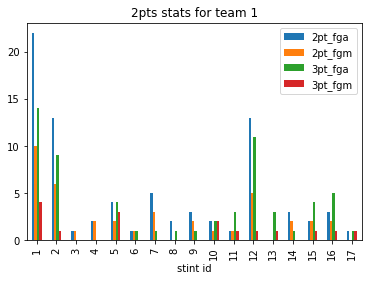

In [386]:
# plot using standard panda plot
# Shooting stats for team 1
axis_y = ['2pt_fga', "2pt_fgm", '3pt_fga', "3pt_fgm"]
stint_stats_df[stint_stats_df.tno == 1].plot(kind="bar", x='stint', y=axis_y, title="2pts stats for team 1", xlabel="stint id")

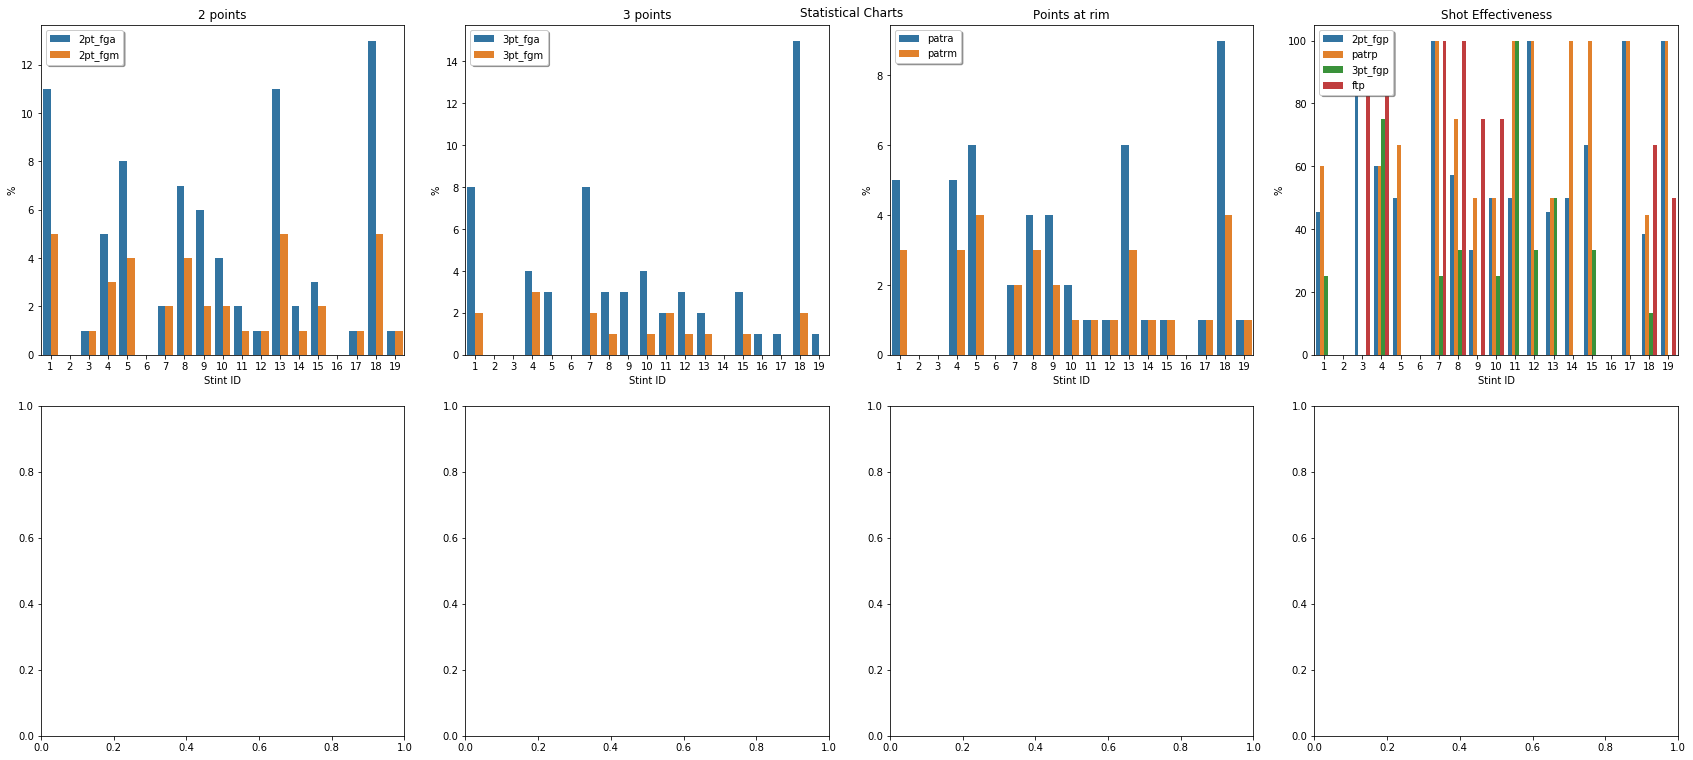

In [388]:
import matplotlib.pyplot as plt
import seaborn as sns

def graph_points(stats_df: pd.DataFrame, col_aggreg: str):

    # First, let's create the overal matrix of subplots
    fig_size = (2, 4)
    # # # Create a 3x5 matrix of subplots and add padding around them for readability.
    # https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplot.html?highlight=subplot#matplotlib.pyplot.subplot
    fig, axes = plt.subplots(nrows=fig_size[0], ncols=fig_size[1], figsize=(24, 11))
    # fig.subplots_adjust(top=0.8)
    # fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
    fig.tight_layout(pad=3.0)
    fig.suptitle("Statistical Charts")


    axis = axes[0, 0]
    df = stats_df[[col_aggreg, '2pt_fga', '2pt_fgm']].melt(id_vars=col_aggreg,  value_name='value', var_name='class')
    g = sns.barplot(ax=axis, data=df, x=col_aggreg, y='value', hue='class')
    g.set_title("2 points")
    g.set_xlabel("Stint ID")
    g.set_ylabel("%")
    g.set_label("sss")
    g.legend(shadow=True) # https://www.dataforeverybody.com/seaborn-legend-change-location-size/

    axis = axes[0, 1]
    df = stats_df[[col_aggreg, '3pt_fga', '3pt_fgm']].melt(id_vars=col_aggreg,  value_name='value', var_name='class')
    g = sns.barplot(ax=axis, data=df, x=col_aggreg, y='value', hue='class')
    g.set_title("3 points")
    g.set_xlabel("Stint ID")
    g.set_ylabel("%")
    g.set_label("sss")
    g.legend(shadow=True) # https://www.dataforeverybody.com/seaborn-legend-change-location-size/

    axis = plt.subplot(fig_size[0], fig_size[1], 3)
    df = stats_df[[col_aggreg, 'patra', 'patrm']].melt(id_vars=col_aggreg,  value_name='value', var_name='class')
    g = sns.barplot(ax=axis, data=df, x=col_aggreg, y='value', hue='class')
    g.set_title("Points at rim")
    g.set_xlabel("Stint ID")
    g.set_ylabel("%")
    g.legend(shadow=True)


    axis = plt.subplot(fig_size[0], fig_size[1], 4)
    df = stats_df[[col_aggreg, '2pt_fgp', 'patrp', '3pt_fgp', 'ftp']].melt(id_vars=col_aggreg,  value_name='value', var_name='class')
    g = sns.barplot(ax=axis, data=df, x=col_aggreg, y='value', hue='class')
    axis.set_title("Shot Effectiveness")
    g.set_title("Shot Effectiveness")
    g.set_xlabel("Stint ID")
    g.set_ylabel("%")
    g.legend(shadow=True)


graph_points(stint_stats_df.loc[stint_stats_df['tno'] == 2], 'stint')

In [390]:
stint_stats_df
stints1_df

,id,lineup,intervals
0,1,"(J. White, J. Lual-Acuil Jr, M. Dellavedova, C...","[(1, 00:10:00, 00:05:53), (2, 00:10:00, 00:07:..."
1,2,"(J. White, J. Lual-Acuil Jr, M. Dellavedova, Y...","[(1, 00:05:53, 00:05:05), (2, 00:07:36, 00:04:..."
2,3,"(J. White, J. Lual-Acuil Jr, M. Dellavedova, Y...","[(1, 00:05:05, 00:04:29)]"
3,4,"(J. Lual-Acuil Jr, M. Peatling, Y. Baba, B. Ne...","[(1, 00:04:29, 00:03:26)]"
4,5,"(M. Peatling, A. Hukporti, Y. Baba, B. Newley,...","[(1, 00:03:26, 00:01:16)]"
5,6,"(J. White, A. Hukporti, B. Newley, C. Agada, S...","[(1, 00:01:16, 00:00:55.700000)]"
6,7,"(J. White, M. Dellavedova, A. Hukporti, C. Aga...","[(1, 00:00:55.700000, 00:00:00), (2, 00:10:00,..."
7,8,"(J. Lual-Acuil Jr, D. Barlow, Y. Baba, C. Agad...","[(2, 00:04:46, 00:03:48)]"
8,9,"(D. Barlow, A. Hukporti, Y. Baba, B. Newley, S...","[(2, 00:03:48, 00:02:15)]"
9,10,"(M. Peatling, M. Dellavedova, A. Hukporti, B. ...","[(2, 00:02:15, 00:01:06)]"
